# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [3]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [5]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [6]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [7]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [8]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

0.006894381437650754

## Entropy

In [9]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [10]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [11]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [12]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [13]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [14]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


The results of depth 'None' and '3' trees are the same because '3' in this case is sufficient to fully split dataset into pure leafs, like with 'None'

In [16]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [17]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [18]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8333333333333334


In [19]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


The more trees - the more accuracy + overfitting handling. So 100 performance on unseen data is better than 10 trees.

Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [20]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [21]:
X_train_total, X_val, y_train_total, y_val = train_test_split(df.drop(columns='target'), 
                                                              df['target'], test_size=0.2, random_state=2020)
X_train, X_test, y_train, y_test = train_test_split(X_train_total, y_train_total, test_size=0.25, random_state=2020)

**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

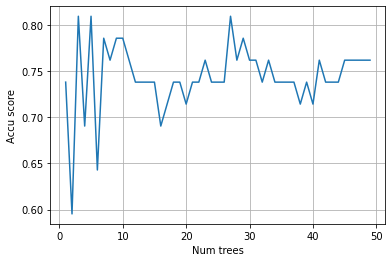

In [30]:
# Finding optimal starting point considering number of estimators. 
# Seems like we can pick 10 as such value according to the plot of accuracy vs n_trees.

accu_list = []
for n in range(1, 50):
    acc = RandomForestClassifier(n_estimators=n, random_state=2020).fit(X_train, y_train).score(X_test, y_test)
    accu_list.append(acc)
    
plt.plot(range(1, len(accu_list) + 1), accu_list)
plt.xlabel('Num trees')
plt.ylabel('Accu score')
plt.grid();

In [32]:
# Picking 10 as initial num of trees.
# We can not just use simple nested loops through the parameters, because it would be Grid search, not Greedy algo.
# So we step-by-step go through parameters in discrete similar cycles. Let's wrap the into a function-helper.

n = 8
initial_params = {'n_estimators': n, 
               'criterion':'gini', 
               'max_depth': None, 
               'min_samples_split': 2, 
               'min_samples_leaf': 1, 
               'random_state': 2020}

def params_greedy(params_dict):
    
    crits = ['gini', 'entropy']
    crits_scores = []
    rf = RandomForestClassifier(**params_dict)
    for crit in crits:
        rf.set_params(criterion=crit)
        acc = rf.fit(X_train, y_train).score(X_test, y_test)
        crits_scores.append(acc)
    params_dict['criterion'] = crits[np.argmax(crits_scores)]


    depths = list(range(1, 10))
    depths_scores = []
    rf = RandomForestClassifier(**params_dict)
    for depth in depths:
        rf.set_params(max_depth=depth)
        acc = rf.fit(X_train, y_train).score(X_test, y_test)
        depths_scores.append(acc)
    params_dict['max_depth'] = depths[np.argmax(depths_scores)]


    split_samples = list(range(2, 10))
    split_samples_scores = []
    rf = RandomForestClassifier(**params_dict)
    for num in split_samples:
        rf.set_params(min_samples_split=num)
        acc = rf.fit(X_train, y_train).score(X_test, y_test)
        split_samples_scores.append(acc)
    params_dict['min_samples_split'] = split_samples[np.argmax(split_samples_scores)]


    leaf_samples = list(range(1, 5))
    leaf_samples_scores = []
    rf = RandomForestClassifier(**params_dict)
    for num in leaf_samples:
        rf.set_params(min_samples_leaf=num)
        acc = rf.fit(X_train, y_train).score(X_test, y_test)
        leaf_samples_scores.append(acc)
    params_dict['min_samples_leaf'] = leaf_samples[np.argmax(leaf_samples_scores)]
    

    # repeat if after tuning of params increasing the number of trees gives performance increase.
    num_trees_scores = []
    rf = RandomForestClassifier(**params_dict)
    n = rf.n_estimators
    for k in range(n, n + 50):
        rf.set_params(n_estimators=k)
        acc = rf.fit(X_train, y_train).score(X_test, y_test)
        num_trees_scores.append(acc)
    if max(num_trees_scores) - num_trees_scores[0] > 0.01:
        params_dict['n_estimators'] = n + np.argmax(num_trees_scores)
        params_dict = params_greedy(params_dict)
    
    return params_dict

In [33]:
# Running

best_params = params_greedy(initial_params)
best_params

{'n_estimators': 27,
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'random_state': 2020}

In [50]:
greedy_val_score = RandomForestClassifier(**best_params).fit(X_train_total, y_train_total).score(X_val, y_val)
print(f"Greedy algo validation score is {round(greedy_val_score, 4)}")

Greedy algo validation score is 0.8095


### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

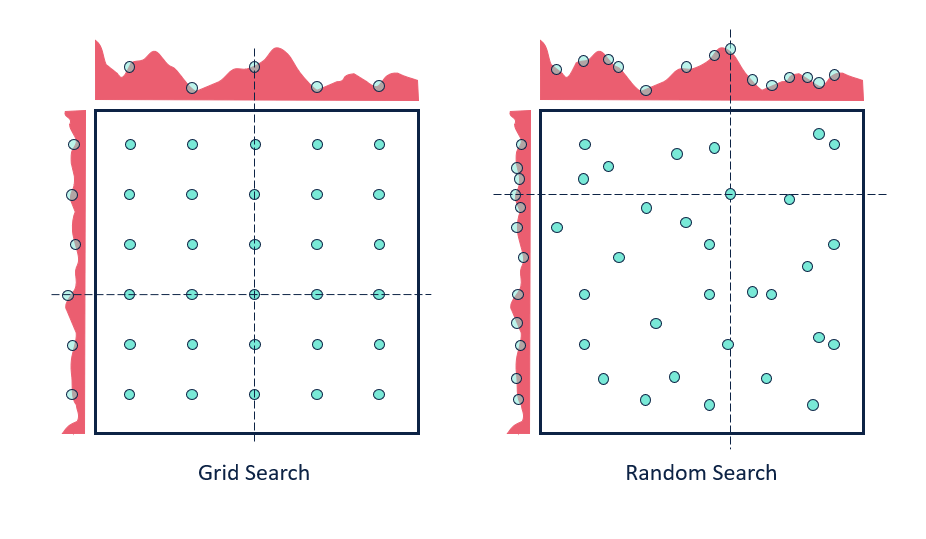

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [43]:
# The range of our parameters tuning is not very wide, so we can afford just including n_estimators into the grid instead of
# tuning other params with some small number of trees and then increase it.

# !! Still the time of execution is rather big, pls note that if going to run the next cell with .fit().!!

rf_param_grid = {'n_estimators': list(range(1, 100, 5)), 
                 'criterion': ['gini', 'entropy'], 
                 'max_depth': list(range(1, 10)), 
                 'min_samples_split': list(range(2, 10)), 
                 'min_samples_leaf': list(range(1, 5))}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=2020), rf_param_grid, n_jobs=-1)

In [44]:
rf_grid.fit(X_train_total, y_train_total)

GridSearchCV(estimator=RandomForestClassifier(random_state=2020), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                          51, 56, 61, 66, 71, 76, 81, 86, 91,
                                          96]})

In [46]:
# the best params found by GridSearch

rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 31}

In [49]:
grid_val_score = rf_grid.score(X_val, y_val)
print(f"Grid search validation score is {round(grid_val_score, 4)}")

Grid search validation score is 0.8571


*Grid search performed significantly better than Greedy algo, resulting in over 5% accuracy increase on unseen data.*

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [68]:
# Let's use the same parameters range except for n_estimators, where we do linspace up to 100 trees instead of stepping by 5

rf_param_rand = {'n_estimators': list(range(1, 100)), 
                 'criterion': ['gini', 'entropy'], 
                 'max_depth': list(range(1, 10)), 
                 'min_samples_split': list(range(2, 10)), 
                 'min_samples_leaf': list(range(1, 5))}
rf_rand = RandomizedSearchCV(RandomForestClassifier(random_state=2020), rf_param_rand, n_iter=100, n_jobs=-1, random_state=2020)

In [69]:
rf_rand.fit(X_train_total, y_train_total)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=2020),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=2020)

In [70]:
# the best params found by RandomSearch

rf_rand.best_params_

{'n_estimators': 40,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 6,
 'criterion': 'entropy'}

In [71]:
rand_val_score = rf_rand.score(X_val, y_val)
print(f"Random search validation score is {round(rand_val_score, 4)}")

Random search validation score is 0.8333


*Random search performance in our case with 100 iterations lies between Greedy algo and Grid search, resulting in about 2.5% accuracy increase on unseen data comparing to Greedy and about 2.5% decrease comparing to Grid. But there were some details, they are described below*

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

My custom **greedy algo** has done well (about *81%* accu), still being the poorest in quality of produced parameters for RF model. But it worked very quickly even though using single CPU core.  
**Grid search** performed the best (about *85.7%* accu) but it lasted for ages even with all CPU cores envolved. Though the dataset is really tiny, number and range of params tuned is rather modest and I even have set the step for trees number by 5. If I had set it by 1, I would run old before getting the result, I guess.  
**Random Search**'s behavior was rather interesting still not very predictable even with random seed fixed: I recieved results *from 0.8 to 0.85* accu depending on number of samples (iters) from 100 to 500 and not always more iters search was better in accu (500 was the worst, actually). I think it hasn't outperformed Grid Search because we didn't have any continuously distributed params, such as regularization coef or somthing. Random search could find something useful between spots used by Grid search. Also if we had really large dataset or had to tune bigger amount of params, we simply wouldn't get an opportunity to run appropriate range of params' values with Grid search.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [72]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# your code here

In [73]:
titanic = pd.read_csv(PATH + 'train.csv').set_index('PassengerId')
test_data = pd.read_csv(PATH + 'test.csv').set_index('PassengerId')

In [74]:
# save the last index in train set for further convenience

train_ind_max = titanic.index.max()

In [76]:
# combining train and test data for processing

titanic_alldata = titanic.append(test_data)

In [77]:
titanic_alldata.isna().sum()

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [78]:
# simple na filling in some columns

titanic_alldata['Age'] = titanic_alldata.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))
#titanic_alldata['Embarked'] = titanic_alldata['Embarked'].fillna('C')
titanic_alldata['Fare'] = titanic_alldata.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.mean()))

In [79]:
# dropping some columns as we don't need advanced feature engineering in this task

titanic_alldata = titanic_alldata.drop(columns=['Cabin', 'Name', 'Ticket', 'Embarked'])

In [80]:
titanic_alldata = pd.get_dummies(titanic_alldata)

In [81]:
# dividing back to train and test

titanic_train_prepared = titanic_alldata[titanic_alldata.index <= train_ind_max]
X_train, X_test, y_train, y_test = train_test_split(titanic_train_prepared.drop(columns='Survived'), 
                                                    titanic_train_prepared['Survived'], random_state=2020)

In [83]:
# grid search for tree params

tree_param_grid = {'criterion': ['gini', 'entropy'], 
                 'max_depth': list(range(1, 10)), 
                 'min_samples_split': list(range(2, 10)), 
                 'min_samples_leaf': list(range(1, 5)), 
                 'max_features': list(range(1, X_train.shape[1] + 1))}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=2020), tree_param_grid, n_jobs=-1)

In [84]:
tree_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=2020), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]})

In [85]:
tree_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 8}

In [88]:
# evaluating on unseen data

print(f"Validation score of single decision tree classifier on unseen data is \n{tree_grid.score(X_test, y_test)}")

Validation score of single decision tree classifier on unseen data is 
0.7892376681614349


As we see, simple and single tree easily competes linear and knn models from previous homework while they nedded advanced feature engineering.

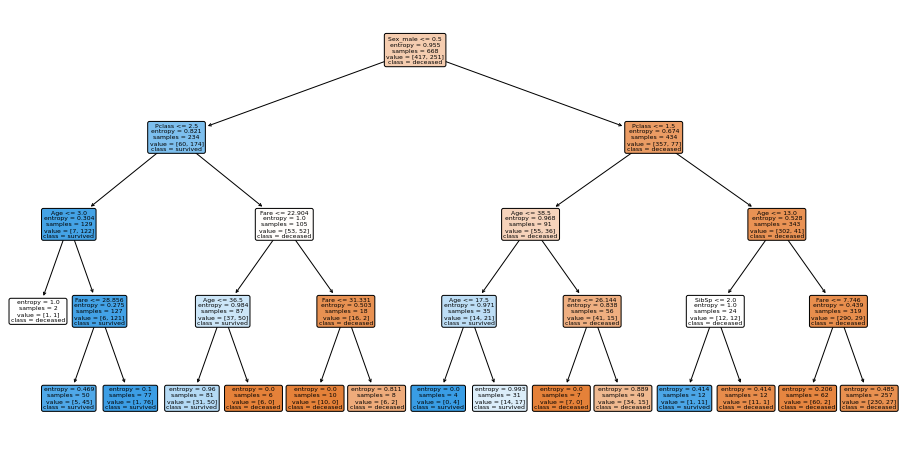

In [89]:
plt.figure(figsize=(16, 8))
plot_tree(tree_grid.best_estimator_, filled=True, rounded=True, feature_names=X_train.columns, 
          class_names=['deceased', 'survived']);

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

*It is rather easy and intuitive to interpret results of the tree plotted, because every node 'asks' concrete interpretable question on some attribute. So one can comparetively easily go the way down the tree to predict whether some person would survive on Titanic.*

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [95]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [96]:
def mse(y_true, y_pred):
    error = np.square(y_true - y_pred).mean()
    return error

# defining custom cost function for splitting criteria

def splits_mse(y_splits):
    mean_error = np.concatenate([np.square(y - np.mean(y)) for y in y_splits]).mean()
    return mean_error

In [97]:
class TreeRegressor(object):
    """A custom decision tree regressor.

    Args:
        criterion : {"mse"}
    """
    def __init__(self, criterion='mse', max_depth=None):
        self.threshold = None
        self.column_index = None
        self.outcome_avg = None
        if criterion == 'mse':
            self.criterion = criterion
            self.criterion_func = splits_mse
        else:
            raise Exception(f"Unknown criterion {self.criterion}.")
        self.max_depth = max_depth
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        min_error, min_col, min_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                mse = self.criterion_func(splits)

                if (min_error is None) or (mse < min_error):
                    min_col, min_val, min_error = column, value, mse
        return min_col, min_val, min_error

    def fit(self, X, y, n_features=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if self.max_depth is not None:
                assert self.max_depth > 0
                self.max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, min_error = self._find_best_split(X, y, n_features)
            assert min_error is not None

            self.column_index = column
            self.threshold = value
            #self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = TreeRegressor(criterion=self.criterion, max_depth=self.max_depth)
            self.left_child.fit(
                left_X, left_target, n_features
            )

            self.right_child = TreeRegressor(criterion=self.criterion, max_depth=self.max_depth)
            self.right_child.fit(
                right_X, right_target, n_features
            )
        except AssertionError:
            self.outcome_avg = np.mean(y)


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_avg

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [99]:
# check the performance of custom tree regressor and compare it to the default one from sklearn lib. 
# We'll use both printing and similarity assertion for different depth values.

for depth in [None, 1, 3, 7, 20]:
    custom_treg = TreeRegressor(criterion='mse', max_depth=depth)
    treg = DecisionTreeRegressor(criterion='mse', max_depth=depth)
    
    custom_treg.fit(X, y)
    treg.fit(X, y)
    
    custom_mse = mse(y, custom_treg.predict(X))
    sk_mse = mse(y, treg.predict(X))
    
    print(f"\nFor max_depth of {depth}:")
    print(f"Custom Tree MSE is {custom_mse}")
    print(f"Sklearn Tree MSE is {sk_mse}")
    
    assert round(custom_mse, 9) == round(sk_mse, 9)    


For max_depth of None:
Custom Tree MSE is 0.0
Sklearn Tree MSE is 0.0

For max_depth of 1:
Custom Tree MSE is 0.03149026259332606
Sklearn Tree MSE is 0.03149026259332607

For max_depth of 3:
Custom Tree MSE is 0.011079705804072996
Sklearn Tree MSE is 0.011079705804072996

For max_depth of 7:
Custom Tree MSE is 0.0005604136727744339
Sklearn Tree MSE is 0.0005604136727744339

For max_depth of 20:
Custom Tree MSE is 0.0
Sklearn Tree MSE is 0.0


**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [100]:
class RandomForestRegressorCustom(object):
    """
    A custom random forest regressor.
    A random forest is a meta estimator that fits a number of decision tree
    regressors on various sub-samples of the dataset and uses averaging to
    improve the predictive performance based on criterion set and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"mse"}, default="mse"
            The function to measure the quality of a split. Supported criteria is
            "mse" for the mean squared error.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="mse", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "mse":
            self.criterion = criterion
            self.criterion_func = splits_mse
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [TreeRegressor(criterion=self.criterion, max_depth=self.max_depth) for _ in range(self.n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = X.shape[1]
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [101]:
from sklearn.ensemble import RandomForestRegressor

# check the performance of custom Random Forest Regressor and compare it to the default one from sklearn lib. 
# We'll use both printing and similarity assertion for different depth values.
# Important note: To assert similarity of forests we must turn bootstrapping off as it is randomized feature 
# and we don't have random state functionality in our custom Forest.

for depth in [None, 1, 3, 7, 20]:
    custom_RFReg = RandomForestRegressorCustom(criterion='mse', bootstrap=False, max_depth=depth)
    RFReg = RandomForestRegressor(n_estimators=10, max_features='auto', criterion='mse', max_depth=depth, bootstrap=False)
    custom_RFReg.fit(X, y)
    RFReg.fit(X, y)
    custom_mse = mse(y, custom_RFReg.predict(X))
    sk_mse = mse(y, RFReg.predict(X))
    print(f"\nFor max_depth of {depth}:")
    print(f"Custom RFRegressor MSE is {custom_mse}")
    print(f"Sklearn RFRegressor MSE is {sk_mse}")
    
    assert round(custom_mse, 9) == round(sk_mse, 9)


For max_depth of None:
Custom RFRegressor MSE is 9.899279914150392e-33
Sklearn RFRegressor MSE is 9.899279914150392e-33

For max_depth of 1:
Custom RFRegressor MSE is 0.03149026259332607
Sklearn RFRegressor MSE is 0.03149026259332607

For max_depth of 3:
Custom RFRegressor MSE is 0.011079705804073
Sklearn RFRegressor MSE is 0.011079705804072996

For max_depth of 7:
Custom RFRegressor MSE is 0.0005604136727744339
Sklearn RFRegressor MSE is 0.0005604136727744339

For max_depth of 20:
Custom RFRegressor MSE is 9.899279914150392e-33
Sklearn RFRegressor MSE is 9.899279914150392e-33


# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [102]:
import joblib
from joblib import parallel_backend
from joblib import Parallel, delayed
import time

In [103]:
class RFRegressorCustomMulti(object):
    """
    A custom random forest regressor.
    A random forest is a meta estimator that fits a number of decision tree
    regressors on various sub-samples of the dataset and uses averaging to
    improve the predictive performance based on criterion set and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"mse"}, default="mse"
            The function to measure the quality of a split. Supported criteria is
            "mse" for the mean squared error.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="mse", bootstrap=True, n_jobs=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.n_jobs = n_jobs
        
        if criterion == "mse":
            self.criterion = criterion
            self.criterion_func = splits_mse
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [TreeRegressor(criterion=self.criterion, max_depth=self.max_depth) for _ in range(self.n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = X.shape[1]
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        self.trees = Parallel(n_jobs=self.n_jobs, prefer="processes")(
                delayed(self._fit_single_tree)(X, y, tree=tree) for tree in self.trees)
        
        
    def _fit_single_tree(self, X, y, tree):
        if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
        else:
            X = self.X
            y = self.y

        tree.fit(
            X,
            y,
            n_features=self.n_features
        )
        return tree
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [104]:
# create bigger dataset by increasing number of features by 10 times.

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 50))
y = f(X)

In [105]:
# first, checking that our multi-processed forest predicts correctly.

for depth in [None, 1, 3, 7, 20]:
    custom_RFReg_multi = RFRegressorCustomMulti(criterion='mse', max_depth=depth, bootstrap=False, n_jobs=2)
    RFReg_sklearn = RandomForestRegressor(n_estimators=10, max_features='auto', criterion='mse', 
                                          max_depth=depth, bootstrap=False, n_jobs=2)
    custom_RFReg_multi.fit(X, y)
    RFReg_sklearn.fit(X, y)
    custom_mse = mse(y, custom_RFReg_multi.predict(X))
    sk_mse = mse(y, RFReg_sklearn.predict(X))
    print(f"\nFor max_depth of {depth}:")
    print(f"Custom RFRegressor MSE is {custom_mse}")
    print(f"Sklearn RFRegressor MSE is {sk_mse}")
    
    assert round(custom_mse, 9) == round(sk_mse, 9)


For max_depth of None:
Custom RFRegressor MSE is 1.0122687787699312e-32
Sklearn RFRegressor MSE is 1.0122687787699312e-32

For max_depth of 1:
Custom RFRegressor MSE is 0.02872363329427376
Sklearn RFRegressor MSE is 0.02872363329427376

For max_depth of 3:
Custom RFRegressor MSE is 0.00865989796346459
Sklearn RFRegressor MSE is 0.008659897963464587

For max_depth of 7:
Custom RFRegressor MSE is 8.4698179128712e-05
Sklearn RFRegressor MSE is 8.4698179128712e-05

For max_depth of 20:
Custom RFRegressor MSE is 1.0122687787699312e-32
Sklearn RFRegressor MSE is 1.0122687787699312e-32


In [106]:
# measuring execution time for different numbers of trees in ensemble and different number of CPU cores used both for 
# our custom forest and the one from sklearn.

# !!Note: rather time-consuming cell to run.!!

trees = [1, 10, 50, 100, 200]
times_cores = {}

for j in [None, 2, 3, 4]:
    time_vs_trees = []
    skl_time = []
    for n in trees:
        custom_RFReg_multi = RFRegressorCustomMulti(n_estimators=n, criterion='mse', max_depth=3, n_jobs=j)
        tic = time.perf_counter()
        custom_RFReg_multi.fit(X, y)
        toc = time.perf_counter()
        time_vs_trees.append(toc - tic)
        
        RFReg_sklearn = RandomForestRegressor(n_estimators=n, criterion='mse', max_depth=3, n_jobs=j)
        tic = time.perf_counter()
        RFReg_sklearn.fit(X, y)
        toc = time.perf_counter()
        skl_time.append(toc - tic)
    times_cores[f"n_jobs={j}"] = time_vs_trees
    times_cores[f"sklearn_n_jobs={j}"] = skl_time

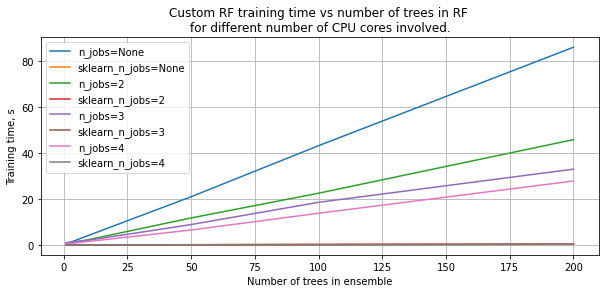

In [107]:
# plotting the results.

plt.figure(figsize=(10, 4))
for jobs, times in times_cores.items():
    plt.plot(trees, times, label=jobs)
plt.title('Custom RF training time vs number of trees in RF \nfor different number of CPU cores involved.')
plt.xlabel('Number of trees in ensemble')
plt.ylabel('Training time, s')
plt.legend()
plt.grid()

Well, we see, that our custom multi-process Random Forest Regressor is able to parallelize trees fitting among CPU cores which leads to significant increase in operating speed and decrease of time consumption needed for ensemble training compared to single-core version.  
Buuut in comparison with highly optimized sklearn Random Forest the one we created is like a fat snail=)